In this project, we are going to explore the database, 'chinook.db'. We are going to come up with some business questions that might be interesting. Then we'll try to answer them with SQL. This project is an extended version of a guided project from dataquest, you can check them out [here](https://dataquest.io).

First, we want to create two helper functions:

1) A function that can execute a SQL query and return the result in pandas.

2) A function that can execute a SQL command.

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def run_query(query):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(query, conn)


def run_command(command):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)

Below, I've attached an image of the database scehma.

<div style="text-align:center">
<img src="images/chinook/relationchart.png" alt="database schema"/>
</div>

In [2]:
def show_tables():
    q = '''
        SELECT
            name,
            type
        FROM sqlite_master
        WHERE type IN ("table","view");
        '''
    return run_query(q)

show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


### Determining the Best Genre

Suppose that the company wants to know which genre sells the best in the United States. They need this information to figure what albums to add to the store. We can extract this information from our SQL database using multiple joins. Then load the result into a pandas dataframe and perform analysis using matplotlib/seaborn.


Here is the list of artists and their respective genres that the company is considering:

1) Regal, hip-hop

2) Red Tone, punk

3) Slim Jim Bites, blues

4) Meteor and the Girls, pop

In [3]:
q1 = '''
WITH usa_sales AS
    (
    SELECT
        g.name Genre,
        SUM(i.quantity) Tracks_sold
    FROM customer c
    INNER JOIN invoice inv ON inv.customer_id = c.customer_id
    INNER JOIN invoice_line i on i.invoice_id = inv.invoice_id
    INNER JOIN track t ON t.track_id = i.track_id
    INNER JOIN genre g ON t.genre_id = g.genre_id
    WHERE country = 'USA'
    GROUP BY Genre
    )

SELECT
    Genre,
    Tracks_sold,
    CAST(Tracks_sold AS FLOAT)/(SELECT SUM(Tracks_sold) FROM usa_sales) AS Percentage
FROM usa_sales
GROUP BY 2
ORDER BY 2 DESC;
'''


genre_and_sales = run_query(q1)

genre_and_sales

,Genre,Tracks_sold,Percentage
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Pop,22,0.020932
7,Hip Hop/Rap,20,0.019029
8,Jazz,14,0.013321
9,Easy Listening,13,0.012369


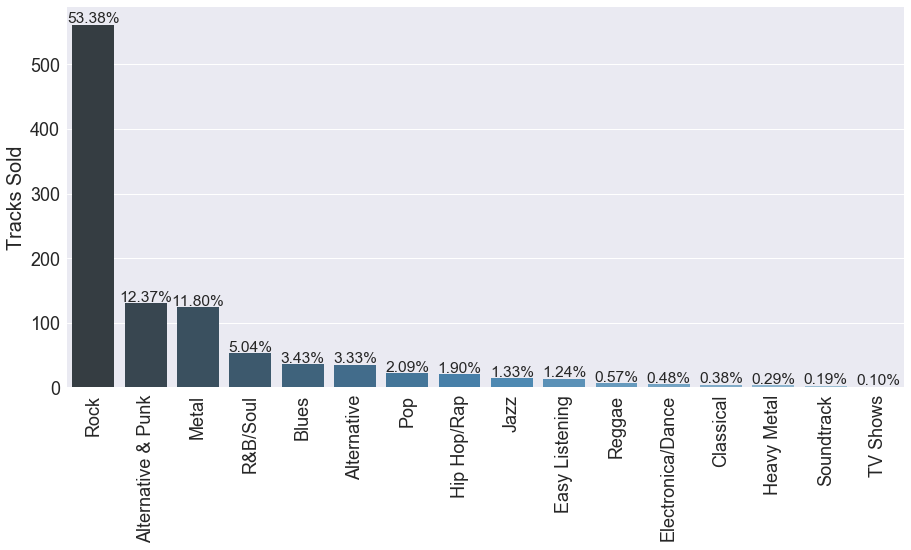

In [4]:
sns.set_style("whitegrid")
sns.set(font_scale=1.8)

fig = plt.figure(figsize=(15,7))
ax = sns.barplot(x="Genre", y="Tracks_sold", data=genre_and_sales, palette="Blues_d")
ax.set_xticklabels(genre_and_sales['Genre'], rotation=90)
percent_labels = genre_and_sales['Percentage']
ax.set_xlabel('')
ax.set_ylabel('Tracks Sold')


sns.set(font_scale=1.3)

#Labels each bar with the percentage of sales.
for i in range(len(ax.patches)):
    p = ax.patches[i]
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(percent_labels.iloc[i]*100)+'%',
            ha="center") 
plt.show()

Let's go over our list:

1) Punk: 12.37% of albums sold in the US.

2) Blues: 3.43% of albums sold in the US.

3) Pop: 2.09% of albums sold in the US.

4) Hip-hop/Rap: 1.9% of albums sold in the US.


If we had to pick one artist out of the four given to us. Based on our data, I would recommend Red Tone, Punk.

### Evaluating Employee Performance

Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. Suppose that our bosses asked us to analyze the sales of each employee to see if any sales support agent is underperforming.

We can follow the same process. First extract this information from our SQL database using multiple joins. Then load the result into a pandas dataframe and perform analysis using matplotlib/seaborn. We can also customize our plots making it easier for others to understand.

In [5]:
q2 = '''
WITH sales_employee AS
    (
    SELECT
        e.employee_id,
        e.first_name,
        e.last_name,
        SUM(i.total) total_sales
    FROM employee e
    INNER JOIN customer c ON c.support_rep_id = e.employee_id
    INNER JOIN invoice i ON i.customer_id = c.customer_id
    GROUP BY e.employee_id 
    )

SELECT
    s.first_name || ' ' || s.last_name Employee_name,
    e.hire_date Hire_date,
    s.total_sales Total_sales
FROM sales_employee s
INNER JOIN employee e ON e.employee_id = s.employee_id
ORDER BY 3 DESC;
'''


sales_per_agent = run_query(q2)

sales_per_agent

,Employee_name,Hire_date,Total_sales
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


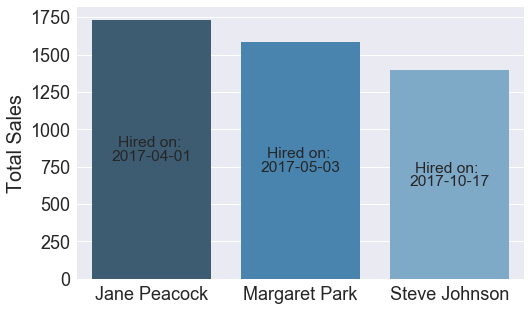

In [6]:
#Generates the bar plot.
sns.set(font_scale=1.8)
fig = plt.figure(figsize=(8,5))
ax = sns.barplot(x="Employee_name", y="Total_sales", data=sales_per_agent, palette="Blues_d")
ax.set_xticklabels(sales_per_agent['Employee_name'])
ax.set_xlabel('')
ax.set_ylabel('Total Sales')

#Labels each bar with the percentage of sales.
sns.set(font_scale=1.3)
percent_labels = sales_per_agent['Hire_date'].apply(lambda x: x.split(' ')[0])
for i in range(len(ax.patches)):
    p = ax.patches[i]
    height = p.get_height()/2
    ax.text(p.get_x()+p.get_width()/2.,
            height + 15,
            'Hired on: ',
            ha="center") 
    ax.text(p.get_x()+p.get_width()/2.,
            height - 75,
            (percent_labels.iloc[i]),
            ha="center") 
plt.show()

Jane had the most sales, but she is also the most senior employee in the sales group. Steve had the least sales but he is also the most junior employee.

I don't believe any of these employees are underperforming relative to each other.

### Analyzing Sales by Country

Suppose that the company wants to advertise their services to other countries. They want to know which country is the best to focus advertisements on. In order words, our bosses wants the most bang for their buck for each customer acquistion. 

To tackle this problem, we would have to use SQL to figure out the average value of sales per customer in each country. Then we can follow the same process and create data visualizations.

In [7]:
q3 = '''
WITH sales_country AS
    (
    SELECT
        CASE
           WHEN (
                 SELECT count(*)
                 FROM customer 
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
        END AS country,
        c.customer_id,
        SUM(i.total) customer_sales
    FROM customer c
    INNER JOIN invoice i ON c.customer_id = i.customer_id
    GROUP BY 2
    ),
    
    orders_country AS
    (
    SELECT
        c.country,
        AVG(i.total) average_country_order
    FROM customer c
    INNER JOIN invoice i ON c.customer_id = i.customer_id
    GROUP BY 1
    )
    

SELECT
    s.country,
    SUM(s.customer_sales) country_sales,
    COUNT(*) total_customers,
    SUM(s.customer_sales)/COUNT(*) average_value_of_sales_per_customer,
    average_country_order
FROM sales_country s
LEFT JOIN orders_country o ON o.country = s.country
GROUP BY 1 
ORDER BY CASE WHEN s.country = 'Other' THEN 2 ELSE 1 END, country_sales DESC

'''

sales_country = run_query(q3)

sales_country

,country,country_sales,total_customers,average_value_of_sales_per_customer,average_country_order
0,USA,1040.49,13,80.037692,7.942672
1,Canada,535.59,8,66.948750,7.047237
2,Brazil,427.68,5,85.536000,7.011148
3,France,389.07,5,77.814000,7.781400
4,Germany,334.62,4,83.655000,8.161463
5,Czech Republic,273.24,2,136.620000,9.108000
6,United Kingdom,245.52,3,81.840000,8.768571
7,Portugal,185.13,2,92.565000,6.383793
8,India,183.15,2,91.575000,8.721429
9,Other,1094.94,15,72.996000,NaN


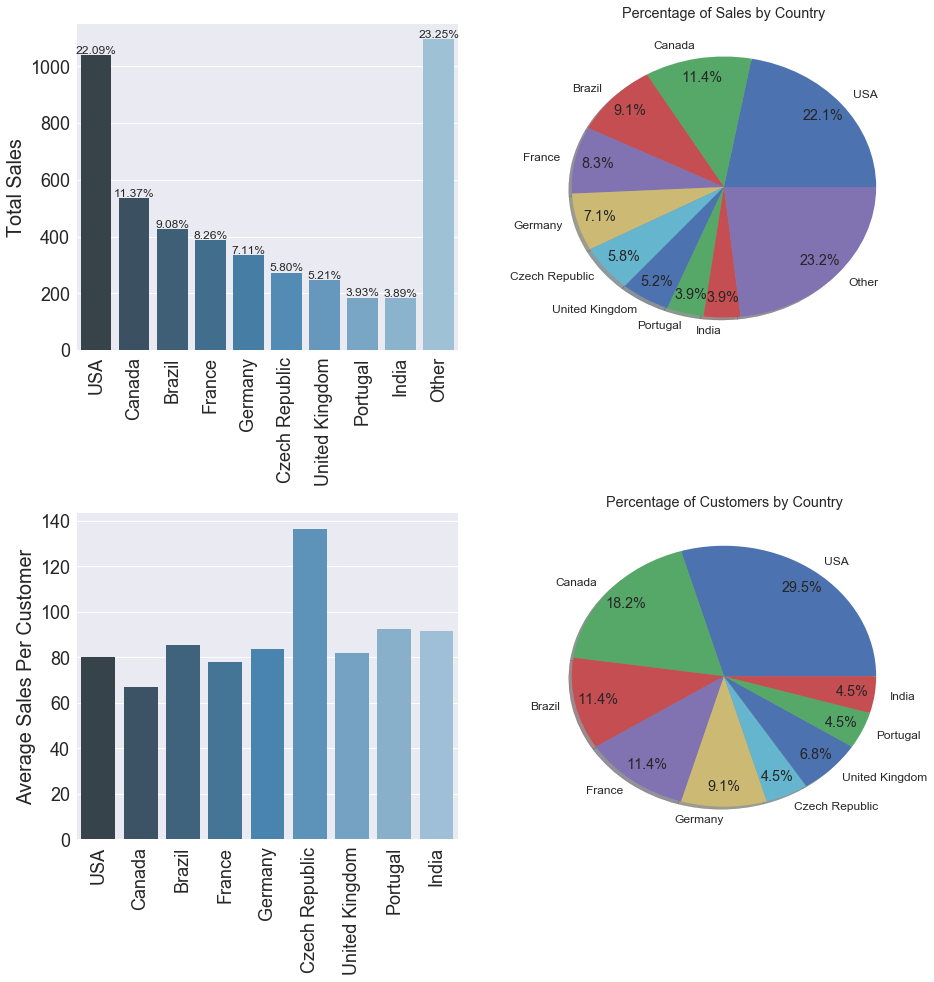

In [8]:
#Generates the sales bar plot.
sales_include_other = sales_country.loc[0:9]
sns.set(font_scale=1.8)
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(2, 2, 1)
ax = sns.barplot(x="country", y="country_sales", data=sales_include_other, palette="Blues_d")
ax.set_xticklabels(sales_include_other['country'], rotation=90)
ax.set_xlabel('')
ax.set_ylabel('Total Sales')

#Generate sales percentage labels.
sns.set(font_scale=1.0)
percent_labels = sales_include_other['country_sales']/sales_include_other['country_sales'].sum()
for i in range(len(ax.patches)):
    p = ax.patches[i]
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2,
            height + 5,
            '{:1.2f}'.format(percent_labels.iloc[i]*100)+'%',
            ha="center")
    
    
#Generate the top pie chart
sns.set(font_scale=1.2)
fig.subplots_adjust(hspace=.5)    
ax2 = fig.add_subplot(2, 2, 2)
ax2 = plt.pie(percent_labels, labels=sales_include_other["country"], autopct='%1.1f%%', shadow=True, pctdistance = 0.85)
plt.title('Percentage of Sales by Country')

#Generate the customer value bar plot
sales_exclude_other = sales_country.loc[0:8]
sns.set(font_scale=1.8)
ax3 = fig.add_subplot(2, 2, 3)
ax3 = sns.barplot(x="country", y="average_value_of_sales_per_customer", data=sales_exclude_other, palette='Blues_d')
ax3.set_xticklabels(sales_exclude_other['country'], rotation=90)
ax3.set_xlabel('')
ax3.set_ylabel('Average Sales Per Customer')


#Generate the bottom pie chart
sns.set(font_scale=1.2)
percent_labels = sales_exclude_other['total_customers']/sales_exclude_other['total_customers'].sum()
ax4 = fig.add_subplot(2, 2, 4)
ax4 = plt.pie(percent_labels, labels=sales_exclude_other["country"], autopct='%1.1f%%', shadow=True, pctdistance = 0.85)
plt.title('Percentage of Customers by Country')

plt.show()

Based on our data, the Czech Republic currently makes up 5.8% of our total sales. They also only make up 4.5% of our customer base. However, they have the highest spending per customer. 

I recommend focusing our marketing efforts on the Czech Republic based on our data.

Note that the sample size we have in our database is extremely low. Even though the people from the Czech Republic have the highest spending per customer, our sample size was 2. Realistically speaking, our conclusions were unreliable.

### Albums vs Tracks

Suppose that the company wants to know if the customers purchase an entire album, or just a single track. 

If the majority of the customers only purchase select track, we could be losing a significant amount of sales. So it could be a good idea to increase the price of selling track seperately. Alternatively, we could sell the entire album at a discount as a promotion.

If the album purchases are too low, the company could drop them entirely from the shop. In that case, we should focus our efforts on purchasing rights to select tracks.

We'll need to write a query that categorizes each invoice as either an album purchase or not, and calculates the following summary statistics:

+ Number of invoices 
+ Percentage of invoices
+ Sales
+ Percentage of Sales

Note: For the invoice table, the customer cannot buy an album AND individual tracks in one purchase.

In [9]:
q6 = '''
WITH invoice_detailed AS
    (SELECT
        t.track_id,
        i.invoice_id,
        (i.total) total
    FROM
        track t
    INNER JOIN invoice_line il ON il.track_id = t.track_id
    INNER JOIN invoice i ON i.invoice_id = il.invoice_id
    GROUP BY i.invoice_id
    )
    
SELECT
    album_purchase,
    COUNT(*) number_of_invoices,
    CAST (COUNT(*) AS FLOAT)/(SELECT COUNT(invoice_id) FROM invoice_detailed) AS invoice_percentage,
    SUM(total) sales,
    CAST (SUM(total) AS FLOAT)/(SELECT SUM(total) FROM invoice_detailed) AS sales_percentage  
FROM 
    (
    SELECT
        ivd.*,
        CASE
            WHEN
                (
                SELECT t.track_id FROM track t 
                WHERE t.album_id = (
                                    SELECT t2.album_id FROM track t2 
                                    WHERE t2.track_id = ivd.track_id
                                    )
                EXCEPT 

                SELECT il2.track_id FROM invoice_line il2
                WHERE il2.invoice_id = ivd.invoice_id
                ) IS NULL
             AND
                (
                SELECT il2.track_id FROM invoice_line il2
                WHERE il2.invoice_id = ivd.invoice_id

                EXCEPT 

                SELECT t.track_id FROM track t
                WHERE t.album_id = (
                                    SELECT t2.album_id FROM track t2
                                    WHERE t2.track_id = ivd.track_id
                                    ) 
                ) IS NULL                                  
            THEN 'Yes'
            ELSE 'No'
        END AS 'album_purchase'
    FROM invoice_detailed ivd
    )
GROUP BY album_purchase
'''

album_purchase = run_query(q6)
album_purchase

,album_purchase,number_of_invoices,invoice_percentage,sales,sales_percentage
0,No,500,0.814332,3248.19,0.68972
1,Yes,114,0.185668,1461.24,0.31028


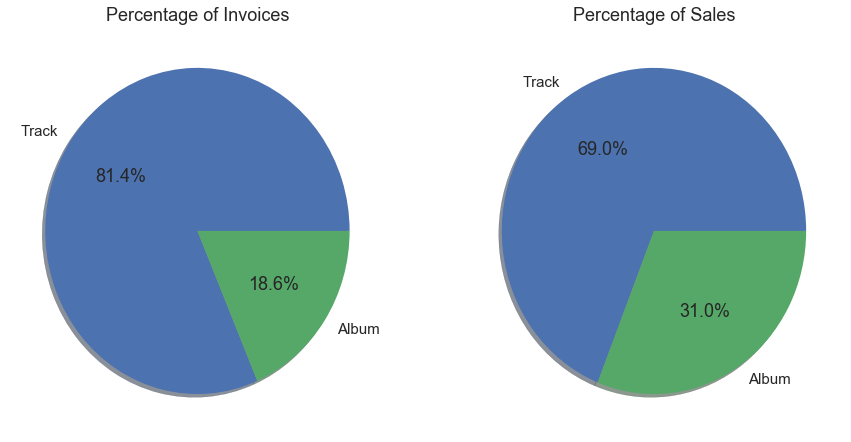

In [10]:
#Figure settings
sns.set(font_scale=1.5)
fig = plt.figure(figsize=(15,7.5))

#Generate the left pie chart.
ax = fig.add_subplot(1, 2, 1)
percent_labels = album_purchase['invoice_percentage']
ax = plt.pie(percent_labels, labels=['Track', 'Album'], autopct='%1.1f%%', shadow=True)
plt.title('Percentage of Invoices')
    
    
#Generate the right pie chart.
ax2 = fig.add_subplot(1, 2, 2)
percent_labels = album_purchase['sales_percentage']
ax2 = plt.pie(percent_labels, labels=['Track', 'Album'], autopct='%1.1f%%', shadow=True)
plt.title('Percentage of Sales')

plt.show()

Based on the data, the album purchases are significant. Album purchases make up 18.57% of the invoices, and 31.02% of the sales.

I recommend not dropping albums from the shop. However, I would suggest doing promotional discounts on unpopular albums. Currently, we are charging customers 99 cents per track. If the customer buys an album with 3 tracks, they are charged 2.97. As a result, many customers are simply selecting tracks they like rather than buying whole albums.



### Determining Best Selling Album

As I mentioned in the previous section, albums make up a significant amount of sales. Suppose that the company is interested in advertising the best performing albums.

We can use SQL/pandas to determine the revenue generated per song. This is going to be the key metric because we want to get the maximum value for each song we purchase the rights for.

In [11]:
q7 = '''
WITH invoice_detailed AS
    (SELECT
        a.album_id,
        a.title,
        t.track_id,
        i.invoice_id,
        (i.total) total
    FROM
        track t
    INNER JOIN invoice_line il ON il.track_id = t.track_id
    INNER JOIN invoice i ON i.invoice_id = il.invoice_id
    INNER JOIN album a ON a.album_id = t.album_id
    GROUP BY i.invoice_id
    ),
    
    songs AS
    (
    SELECT 
        album_id album_key,
        count(*) number_of_songs
    FROM 
        track
    GROUP BY album_key
    )
    
SELECT
    album_id,
    title,
    SUM(total),
    count(*) copies_sold,
    number_of_songs,
    CAST (SUM(total) AS FLOAT)/(number_of_songs) Revenue_per_song      
FROM 
    (
    SELECT
        ivd.*,
        CASE
            WHEN
                (
                SELECT t.track_id FROM track t 
                WHERE t.album_id = (
                                    SELECT t2.album_id FROM track t2 
                                    WHERE t2.track_id = ivd.track_id
                                    )
                EXCEPT 

                SELECT il2.track_id FROM invoice_line il2
                WHERE il2.invoice_id = ivd.invoice_id
                ) IS NULL
             AND
                (
                SELECT il2.track_id FROM invoice_line il2
                WHERE il2.invoice_id = ivd.invoice_id

                EXCEPT 

                SELECT t.track_id FROM track t
                WHERE t.album_id = (
                                    SELECT t2.album_id FROM track t2
                                    WHERE t2.track_id = ivd.track_id
                                    ) 
                ) IS NULL                                  
            THEN 'Yes'
            ELSE 'No'
        END AS 'album_purchase'
    FROM invoice_detailed ivd
    ) q
INNER JOIN songs s ON s.album_key = q.album_id 
WHERE album_purchase = 'Yes' 
GROUP BY album_id
ORDER BY copies_sold DESC
LIMIT 5
'''

album_sales = run_query(q7)
album_sales

,album_id,title,SUM(total),copies_sold,number_of_songs,Revenue_per_song
0,120,Are You Experienced?,100.98,6,17,5.94
1,119,Get Born,51.48,4,13,3.96
2,186,News Of The World,43.56,4,11,3.96
3,157,Miles Ahead,41.58,3,14,2.97
4,188,Green,32.67,3,11,2.97


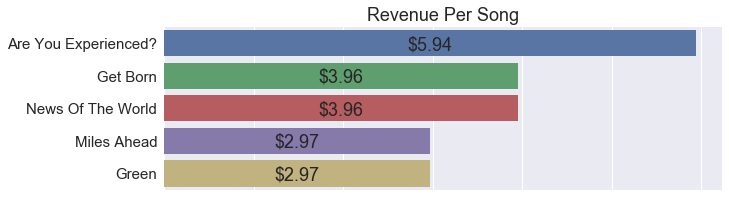

In [12]:
#Figure settings
sns.set(font_scale=1.5)
fig = plt.figure(figsize=(10,3))

#Generate the bar plot
ax = fig.add_subplot(1, 1, 1)
ax = sns.barplot(y="title", x="Revenue_per_song", data=album_sales, palette="deep")
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_xticklabels('')
plt.title('Revenue Per Song') 

#Generate Revenue_per_song labels.
percent_labels = album_sales['Revenue_per_song']
for i in range(len(ax.patches)):
    p = ax.patches[i]
    width = p.get_width()
    ax.text(width/2,
            p.get_y()+p.get_height()-0.2,
            '$'+'{:1.2f}'.format(percent_labels.iloc[i]),
            ha="center")
plt.show()

Based on our data, the best performing album is 'Are You Experienced?' generating $5.94 per song.

Note that our sample size was 6. So it is probably a better idea to gather more data before making an expensive business decision.

### Determining the Best Artists

Suppose the company is interested in knowing which artist is the most valuable to the company. Some artists could have more songs than others. The key metric is the average revenue per song. This metric will be categorized by the artist's name.

Similar to the data analysis process above, we'll use SQL to get the data we need out of the database. Then use pandas/seaborn/matplotlib for data visualization.

In [13]:
q8 = '''
WITH invoice_line_detailed AS
    (
    SELECT
        ar.artist_id,
        ar.name,
        il.quantity,
        il.unit_price
    FROM
        track t
    INNER JOIN invoice_line il ON il.track_id = t.track_id
    INNER JOIN album a ON a.album_id = t.album_id
    INNER JOIN artist ar ON ar.artist_id = a.artist_id
    ),

    tracks_artist AS
    (
    SELECT
        a.artist_id artist_key,
        count(*) songs_in_shop
    FROM
        track t
    INNER JOIN album a ON a.album_id = t.album_id
    INNER JOIN artist ar ON ar.artist_id = a.artist_id
    GROUP BY artist_key
    )

SELECT
    artist_id,
    name Artist,
    SUM(quantity) songs_sold,
    SUM(unit_price) revengue_generated,
    songs_in_shop,
    SUM(unit_price)/CAST (songs_in_shop AS FLOAT) revenue_per_song
FROM invoice_line_detailed ivd
INNER JOIN tracks_artist ta on ta.artist_key = ivd.artist_id 
GROUP BY name
ORDER BY revenue_per_song DESC
'''


artist_sales = run_query(q8)
top_five_artists = artist_sales.iloc[0:5]
top_five_artists

,artist_id,Artist,songs_sold,revengue_generated,songs_in_shop,revenue_per_song
0,196,Cake,31,30.69,1,30.69
1,94,Jimi Hendrix,187,185.13,17,10.89
2,253,Calexico,10,9.90,1,9.90
3,135,System Of A Down,93,92.07,11,8.37
4,240,Gustav Mahler,8,7.92,1,7.92


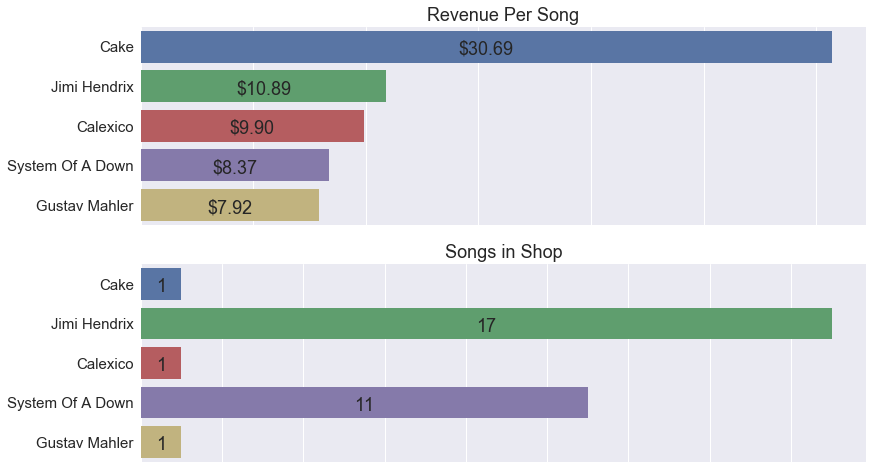

In [14]:
#Figure settings
sns.set(font_scale=1.5)
fig = plt.figure(figsize=(13,8))


#Generate the top bar plot
ax = fig.add_subplot(2, 1, 1)
ax = sns.barplot(y="Artist", x="revenue_per_song", data=top_five_artists, palette="deep")
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_xticklabels('')
plt.title('Revenue Per Song') 

#Generate revenue_per_song labels.
labels = top_five_artists['revenue_per_song']
for i in range(len(ax.patches)):
    p = ax.patches[i]
    width = p.get_width()
    ax.text(width/2,
            p.get_y()+p.get_height()-0.2,
            '$'+'{:1.2f}'.format(labels.iloc[i]),
            ha="center")
    
#Generate the bottom bar plot
ax = fig.add_subplot(2, 1, 2)
ax = sns.barplot(y="Artist", x="songs_in_shop", data=top_five_artists, palette="deep")
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_xticklabels('')
plt.title('Songs in Shop') 

#Generate 'Songs in Shop' labels.
percent_labels = top_five_artists['songs_in_shop']
for i in range(len(ax.patches)):
    p = ax.patches[i]
    width = p.get_width()
    ax.text(width/2,
            p.get_y()+p.get_height()-0.2,
            '{:1.0f}'.format(percent_labels.iloc[i]),
            ha="center")
plt.show()

Immediately we see the artist "Cake" has only one song in shop. However, this one song generated the most revenue($30.69/song) in the entire shop. The artists 'Calexico' and 'Gustav Mahler' also only have one song in our shop. 

My recommendation for the company is to perform more research on these artists with only one song in our shop. We'll need to see if they have more songs that are similar in popularity. It is possible that these artists are actually quite popular, but customers can only find one of their songs in our shop. As a result, we are missing out on potential sales.

---
#### Learning Summary

Concepts explored: data visualization, SQL, business oriented data analysis, seaborn plots

The files used for this project can be found in my [GitHub repository](https://github.com/sengkchu/codingdisciple.content/tree/master/Answering%20Business%20Questions%20using%20SQL).

